# HSLU-PRA Week 4

Date: 08.05.2020

Author: Niclas Simmler

## Task
1. Make yourself familiar with the code (’sw04-01.py’).
2. Add code to select the frequency component(s).
3. Add code to convert the components to a binary sequence.
4. Define the transition matrix.
5. Run the Viterbi decoder for the sequence provided (’morse.wav’). Adjust your transition matrix in case the decoded text is incomprehensible.
6. Add noise to the signal (with help of ’Audacity’, Tracks->add new, generate noise, export) up to the level, at which the decoder start to degrade.
7. (Optional) Train your model with help of the Baum Welch algorithm and repeat step 6.


## Setup


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

from hidden_markov import hmm

#plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 200
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# basic morse dictionary, we use '-' to mark word spaces
alphabet = list('abcdefghijklmnopqrstuvwxyz-')
values = ['.-', '-...', '-.-.', '-..', '.', '..-.', '--.', '....', '..', '.---', '-.-', 
          '.-..', '--', '-.','---', '.--.', '--.-', 
          '.-.', '...', '-', '..-', '...-', '.--', '-..-', '-.--', '--..','-....-']

morse_dict = dict(zip(alphabet, values))
ascii_dict = dict(map(reversed, morse_dict.items())) # inverse mapping


## Helper

Helper functions to handle encoding and decoding.

In [3]:
# convert text to morse code
def morse_encode(text):
    return ' '.join([''.join(morse_dict[i]) for i in text.lower()])
 
# convert morse code to text
def morse_decode(code):
    #return ''.join([ascii_dict[i] for i in code.split(' ')])
    return ''.join([ascii_dict.get(i,'?') for i in code.split(' ')])

def read_audio(path='morse.wav'):
    fs, data = wavfile.read(path)
    return data,fs

def plot_spectrogram(f,t,S):
    plt.figure(0) # spectrogram
    plt.pcolormesh(t, f, S)
    plt.ylabel('frequency [Hz]')
    plt.xlabel('time [sec]')
    plt.title('spectrogram')
    plt.show()
    
def get_spectrogram(data,fs,plot=True):
    # spectral representation
    f, t, S = signal.spectrogram(data, fs)
    if plot:
        plot_spectrogram(f,t,S)
    return f, t, S

## Submission

### Add code to select the frequency component(s).


In [4]:
def select_active_frequencies(S, threshold=0.975):
    '''Return the indexes of S that meet the threshold.
    Threshold will be used to select the quantiles
    '''
    indices = []
    sums = []
    for i, intensity in enumerate(S):
        sums.append(sum(intensity))
    limiter = np.quantile(sums, threshold)
    for i, intensity_sum in enumerate(sums):
        if intensity_sum >= limiter:
            indices.append(i)
    return indices

In [6]:
f, t, S = get_spectrogram(*read_audio(), plot=False)

In [7]:
f_index = select_active_frequencies(S)

### Add code to convert the components to a binary sequence.

In [8]:
def get_binary(S, threshold=0.5):
    '''Return binary representation
    '''
    steps = np.mean(S, axis=0)
    #steps = S[np.argmax(np.sum(S, axis=1)),:]
    return list(map(lambda x: 1 if x >= np.quantile(steps, threshold) else 0, steps))

In [9]:
binary_data = get_binary(S[f_index,:])

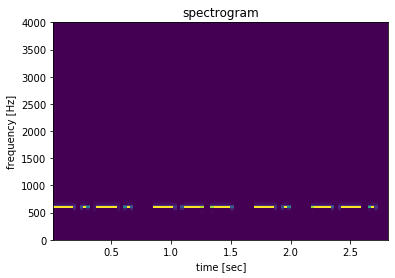

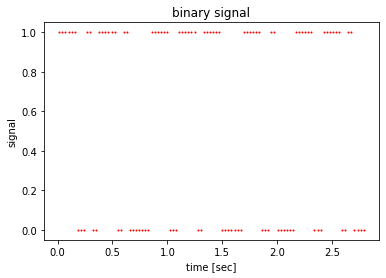

In [16]:
# QC
plt.figure(0) # spectrogram
plt.pcolormesh(t[:n+1], f, S[:,:n])
plt.ylabel('frequency [Hz]')
plt.xlabel('time [sec]')
plt.title('spectrogram')
plt.show()
plt.figure(1)    # binary sequence
plt.plot(t[:n],binary_data[:n],'ro', markersize=1)
plt.ylabel('signal')
plt.xlabel('time [sec]')
plt.title('binary signal')
plt.show()

### Define the transition matrix.


In [14]:
def parse(binary_data, _initial=None,_transition=None,_emission=None):
    #==============================================================================
    # states and symbols used 

    # dot, dash, symbol space, character space, indifferent
    states = ('.1','.2','-1','-2','-3','-4','-5','-6',' 1',' 2','_1','_2','_3','_4','_5','_6','x')
    symbols = (True,False)

    # morse symbols correspondig to states
    state_values = ['.','','-','','','','','','','',' ','','','','','','']
    state_dict = dict(zip(states, state_values))

    # convert state sequence to morse symbols, remove trailing or leading spaces
    def state_decode(sequence):
        return (''.join([''.join(state_dict[i]) for i in sequence])).strip()
    
    #==============================================================================
    # set up and run hidden markov model

    # we assume that we do not start in the middle of a symbol
    initial = np.matrix([
            [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
        ])

    # state  .1 .2 -1 -2 -3 -4 -5 -6  1  2 _1 _2 _3 _4 _5 _6 x    
    transition = np.matrix([
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # .1 
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], # .2 nominal length
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -1
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -2
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -3
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -4
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -5  
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], # -6 nominal length
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], #  1
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], #  2 nominal length
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], # _1
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], # _2
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], # _3
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], # _4
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], # _5
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # _6 nominal length
            [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]  # x  indifferent     
        ])

    # emission probabilities
    emission = np.matrix([
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], # emitting 'True'
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # emitting 'False'
        ]).transpose() 
    
    # scale as probabilities, e.g. that components sum up to 1
    initial = initial / np.sum(initial, axis=1).reshape((-1, 1))
    transition = transition / np.sum(transition, axis=1).reshape((-1, 1))
    emission = emission / np.sum(emission, axis=1).reshape((-1, 1))
    # generate model
    if _initial is not None and _transition is not None and _emission is not None:
        model = hmm(states, symbols, _initial, _transition, _emission)
    else:
        model = hmm(states, symbols, initial, transition, emission)

    # run viterbi decoder
    state_sequence = model.viterbi(binary_data)
    _states = state_decode(state_sequence)
    result = morse_decode(_states)

    print('Morse Code:\n{}'.format(_states))
    print('Decoded string =>',result,'<=')
    return model

In [15]:
_=parse(binary_data)

Morse Code:
-.-. --- -. --. .-. .- - ..- .-.. .- - .. --- -. ... -....- -.-- --- ..- -....- -.. .. -.. -....- ...- . .-. -.-- -....- .-- . .-.. .-..
Decoded string => congratulations-you-did-very-well <=


### Add noise to the signal up to the level, at which the decoder start to degrade.

I generated a plain noise track, which I will introduce gradually within code to the morse signal. The noise signal has the same length as the morse track.

In [13]:
fn, tn, Sn = get_spectrogram(*read_audio(path='noise.wav'), plot=True)


FileNotFoundError: [Errno 2] No such file or directory: 'noise.wav'

Let's generate various new data samples with varying degree of noise.

Adding noise with ratio: 0


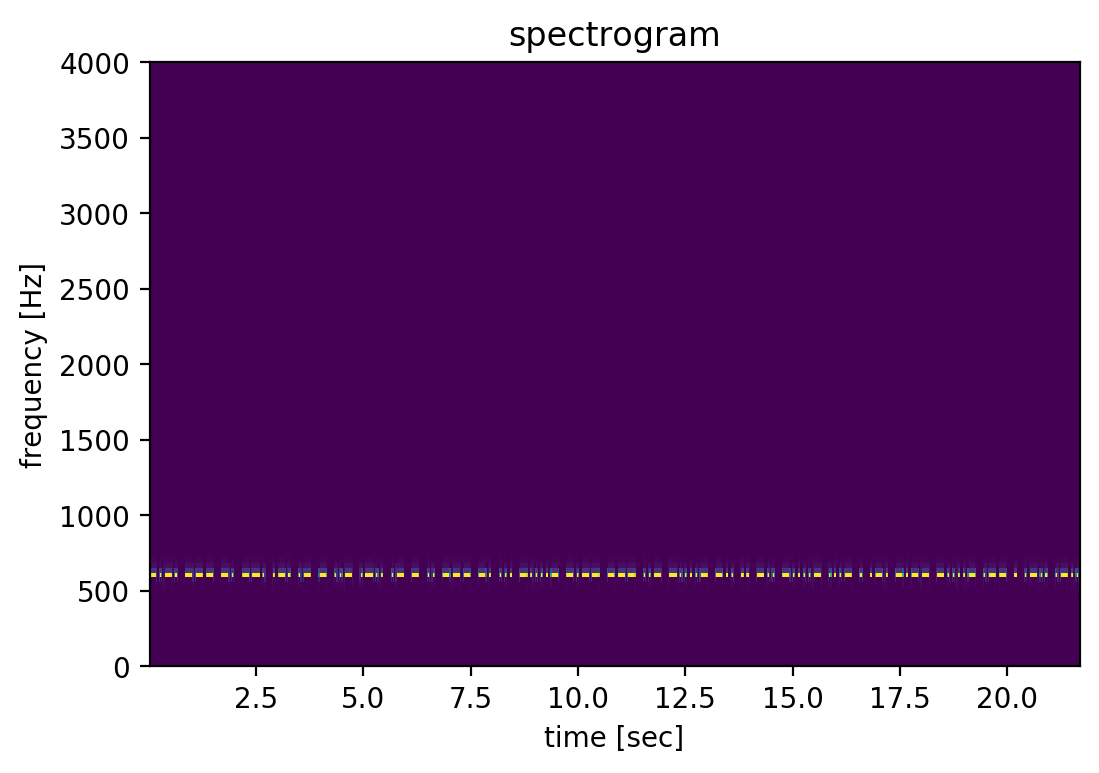

Adding noise with ratio: 1e-05


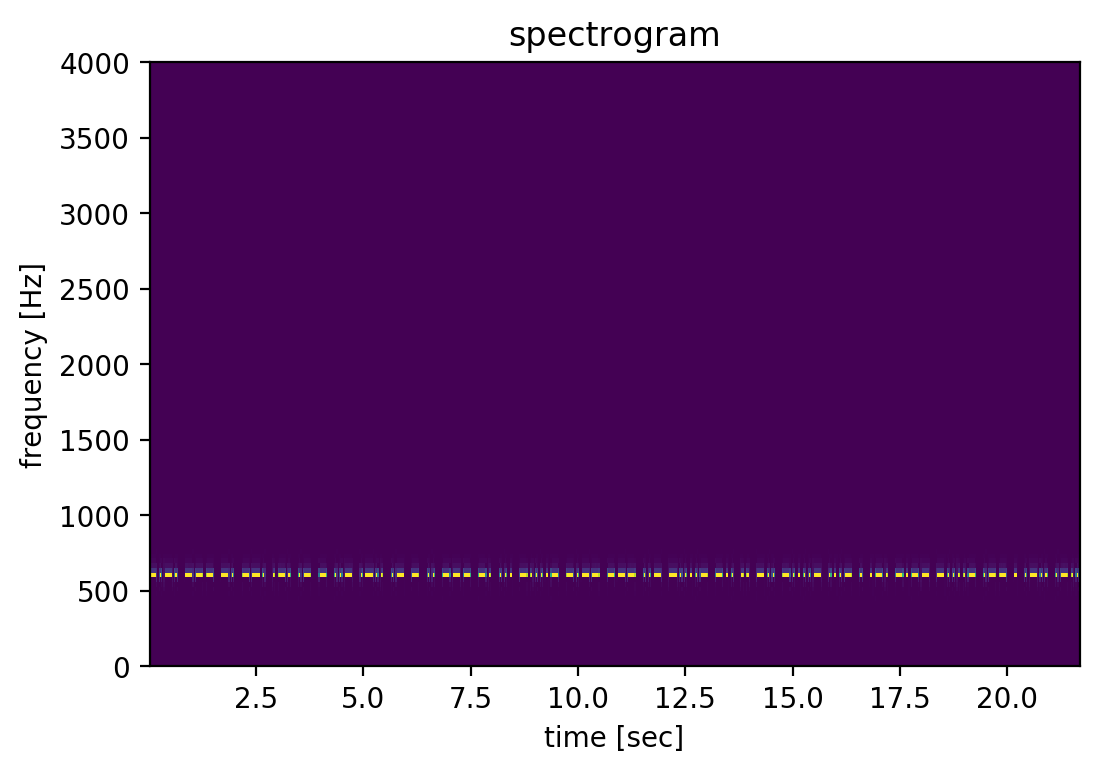

Adding noise with ratio: 5e-05


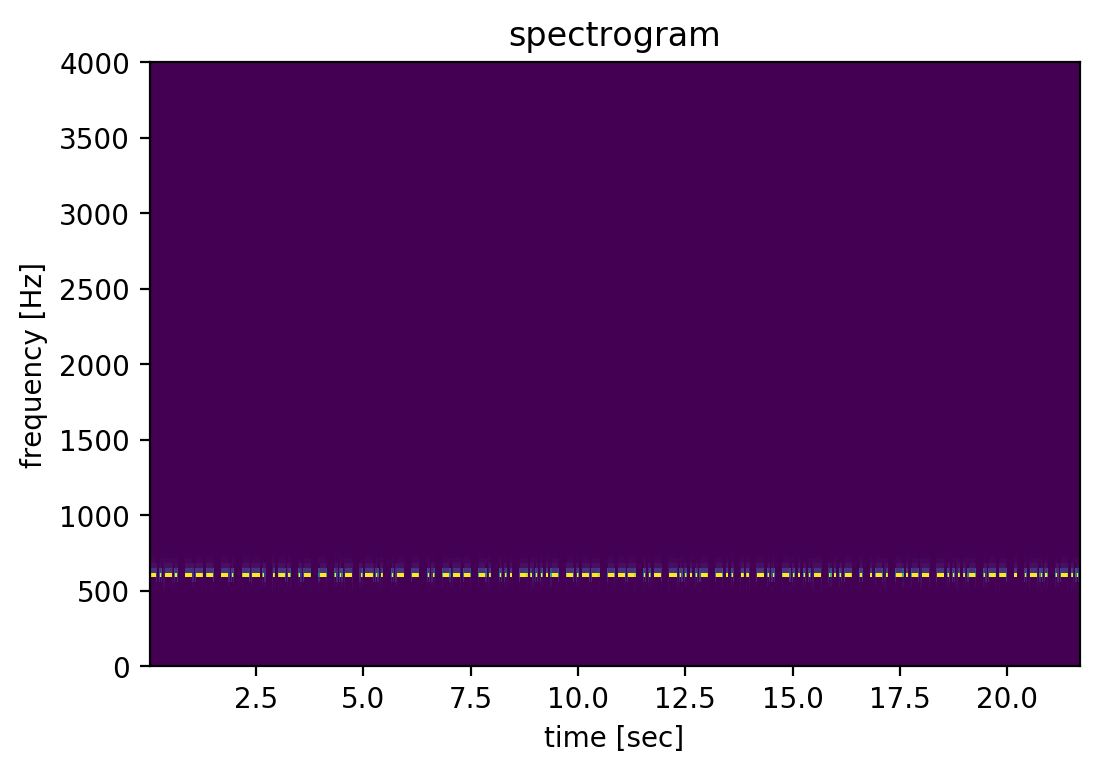

Adding noise with ratio: 0.0001


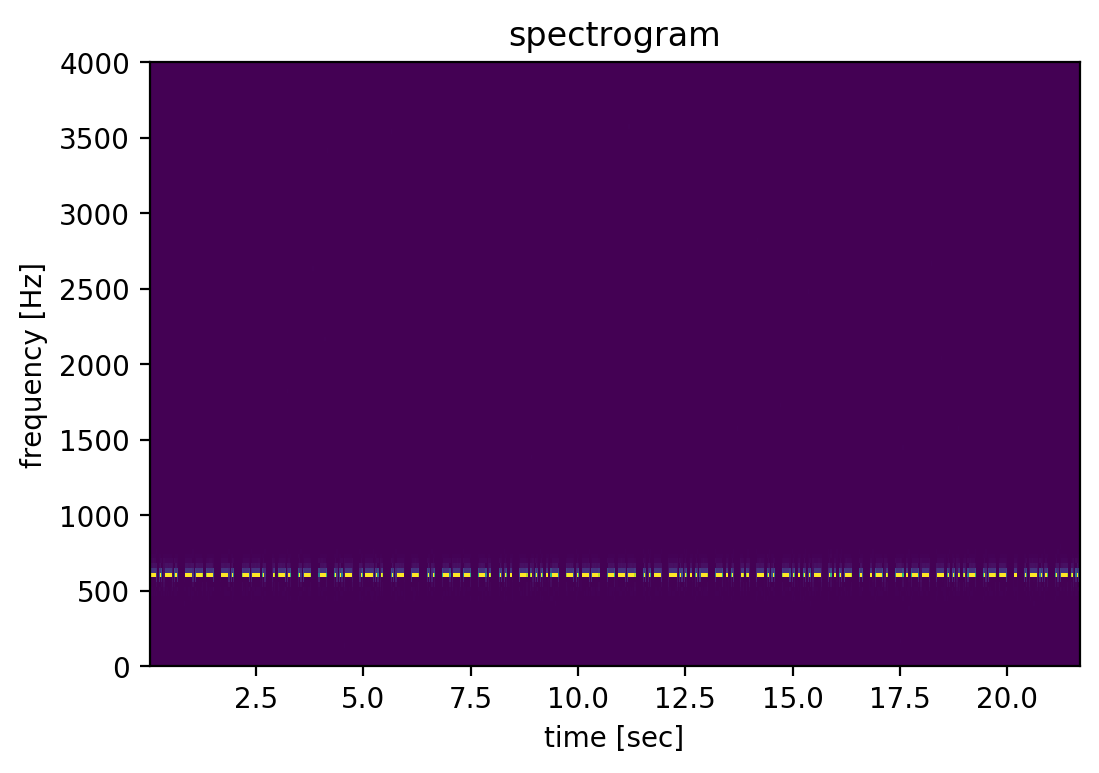

Adding noise with ratio: 0.0005


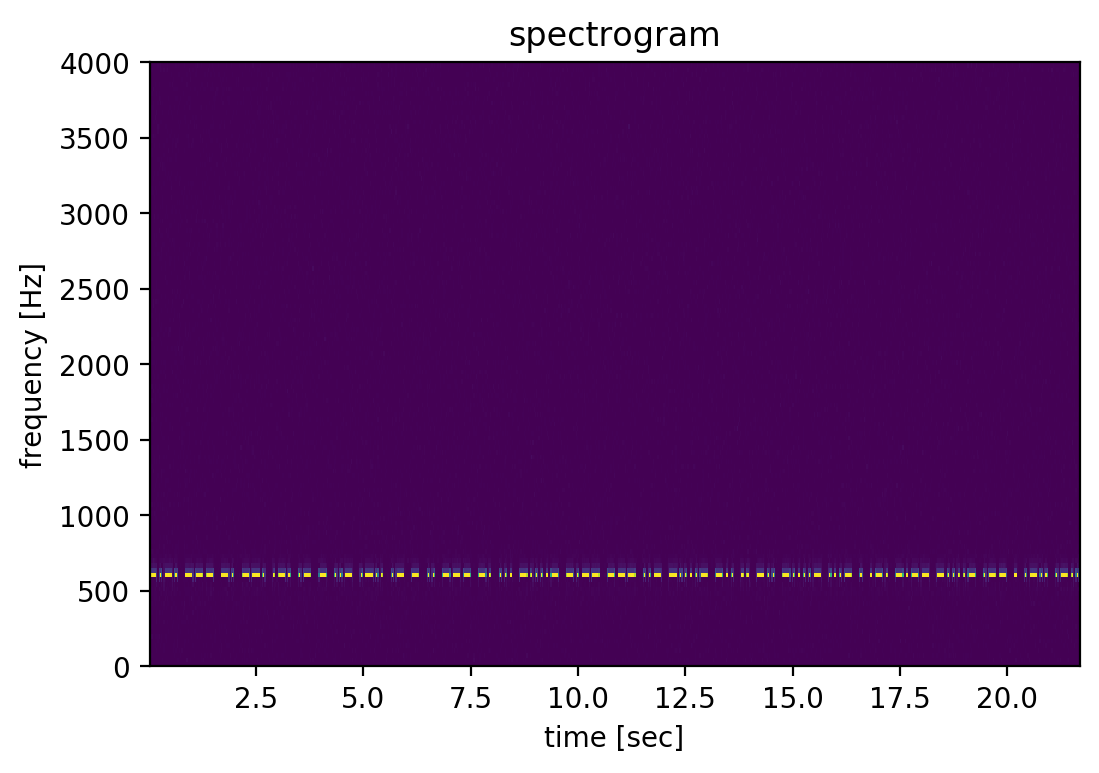

Adding noise with ratio: 0.001


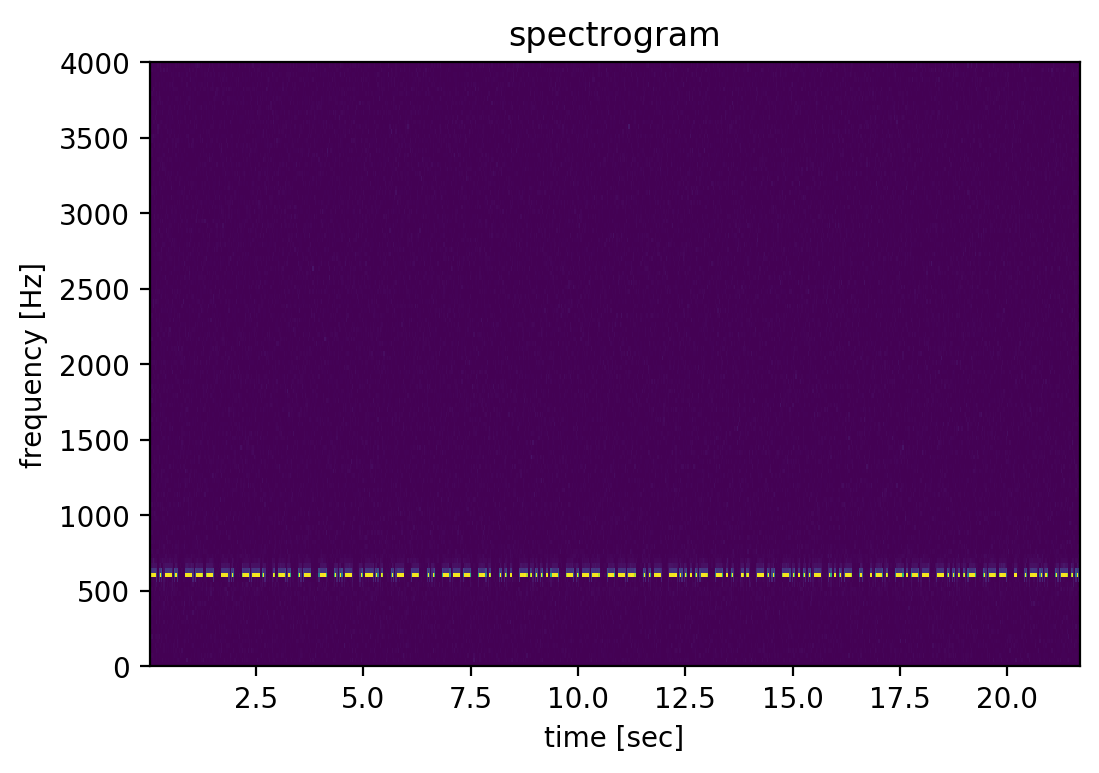

Adding noise with ratio: 0.005


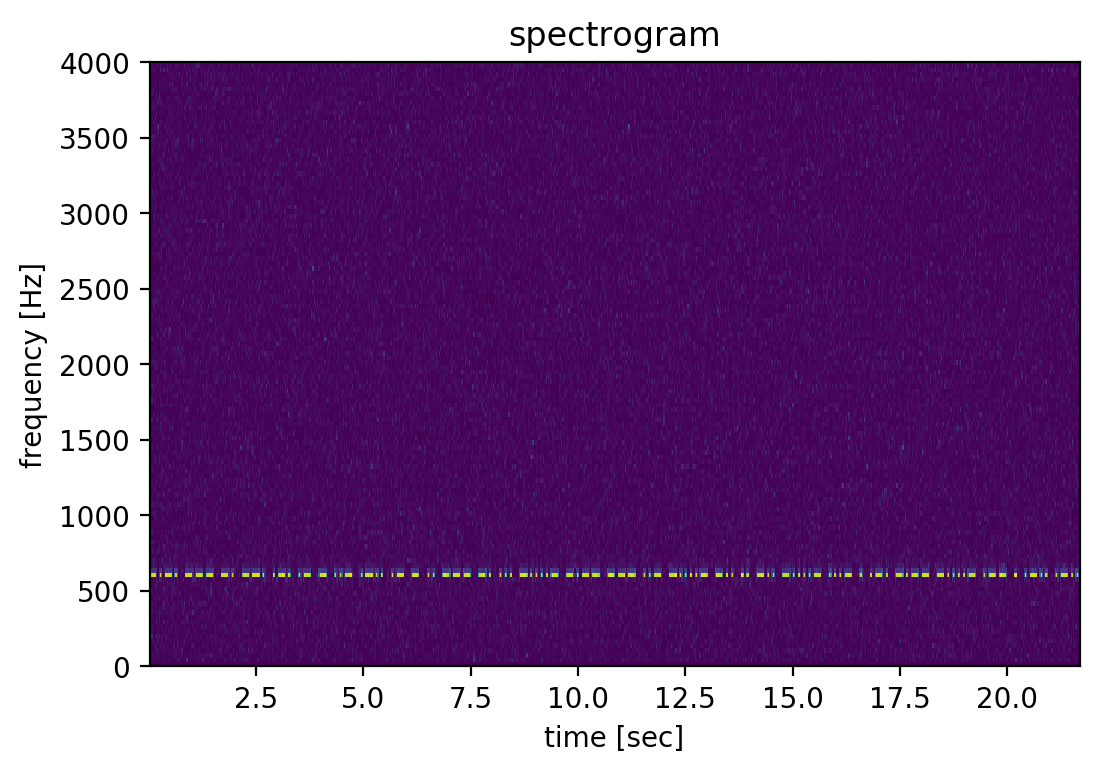

Adding noise with ratio: 0.01


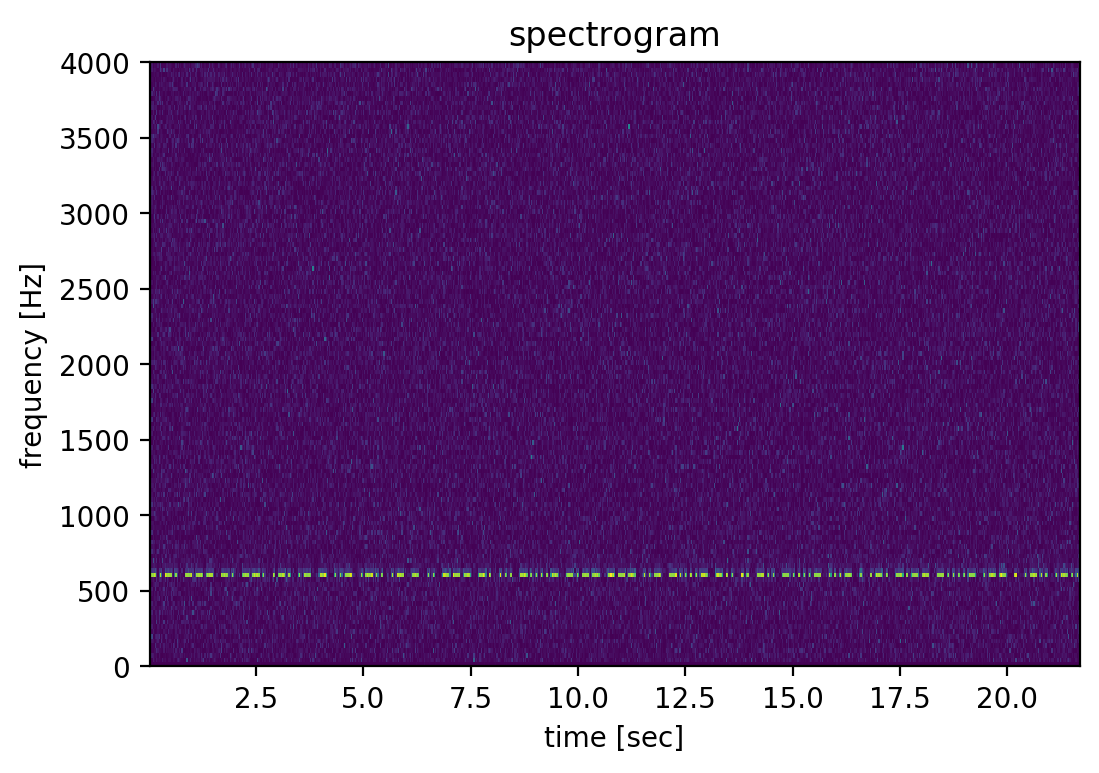

Adding noise with ratio: 0.05


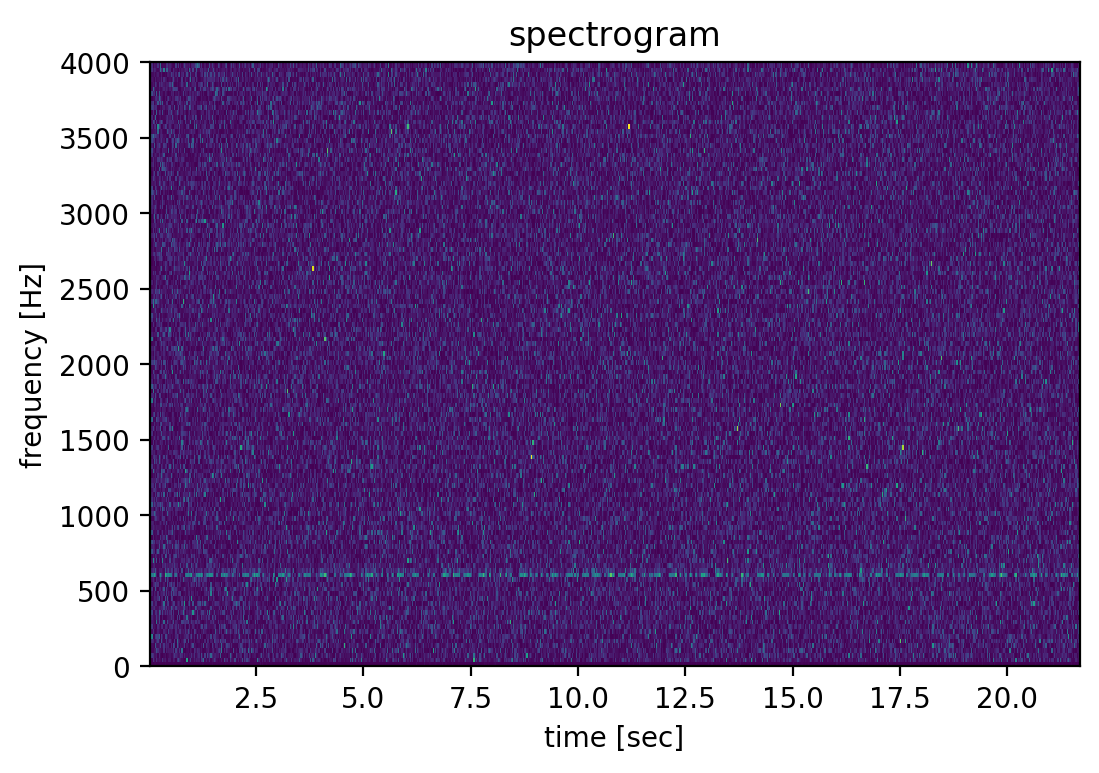

Adding noise with ratio: 0.1


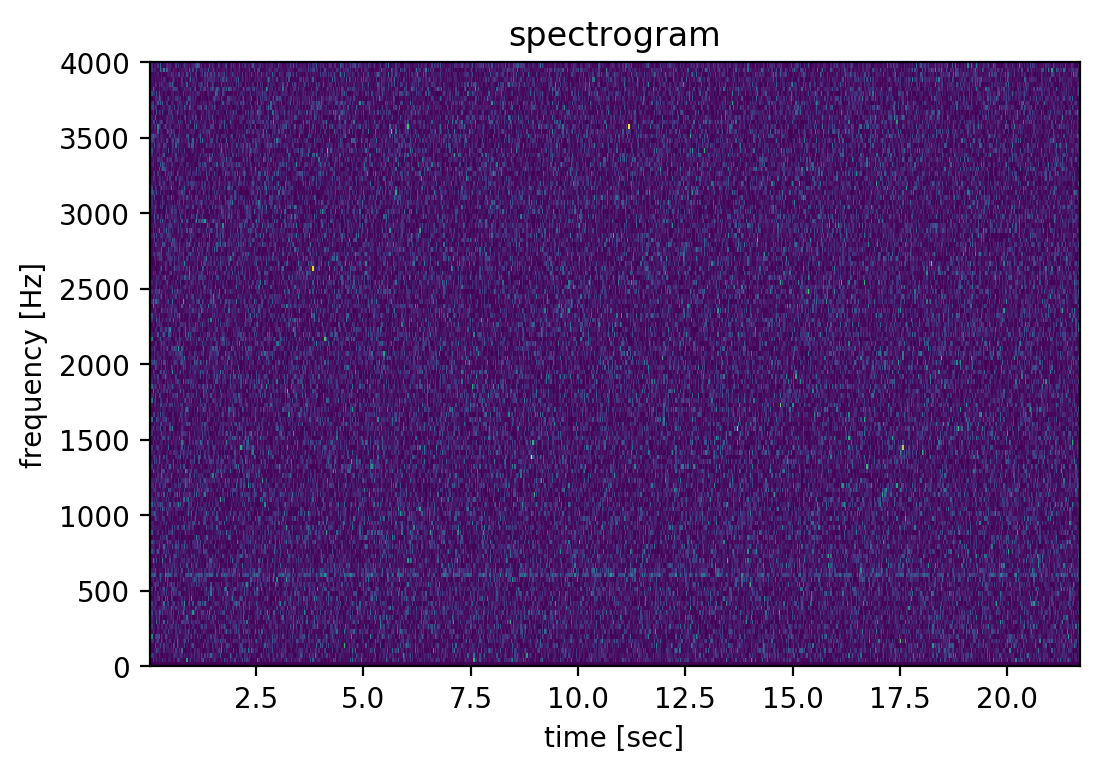

Adding noise with ratio: 0.5


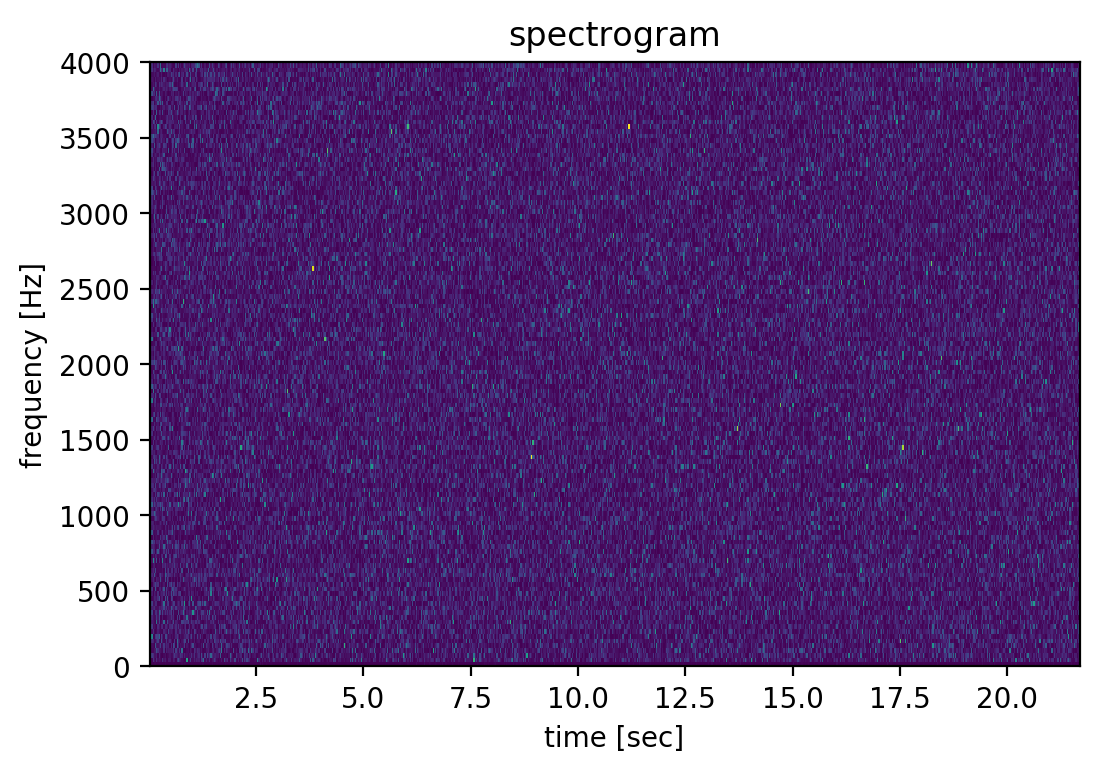

In [13]:
ratios=[0, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
noised_Ss = []
for ratio in ratios:
    print('Adding noise with ratio: {}'.format(str(ratio)))
    new_sample = S*100+Sn*ratio
    plot_spectrogram(f,t,new_sample)
    noised_Ss.append((new_sample,select_active_frequencies(new_sample)))

Attempting to decode of the new samples:

In [14]:
def parse_many(Ss):
    for i, (Sxx, freqs) in enumerate(Ss):
        print('Parse sample with noise ratio: {}'.format(str(ratios[i])))
        _=parse(get_binary(Sxx[freqs,:]))

parse_many(noised_Ss)

Parse sample with noise ratio: 0
Morse Code:
-.-. --- -. --. .-. .- - ..- .-.. .- - .. --- -. ... -....- -.-- --- ..- -....- -.. .. -.. -....- ...- . .-. -.-- -....- .-- . .-.. .-..
Decoded string => congratulations-you-did-very-well <=
Parse sample with noise ratio: 1e-05
Morse Code:
-.-. --- -. --. .-. .- - ..- .-.. - - . --- -. ... -...- -.-- --- .- -...- -.. .. -.. -....- ...- . .-. -.-- -....- .-- . .-. .-.
Decoded string => congratultteons?yoa?did-very-werr <=
Parse sample with noise ratio: 5e-05
Morse Code:
-.-. --- -. --. .-. .- - ..- .-.. - - . --- -. ... -...- -.-- --- .- -...- -.. .. -.. -....- ...- . .-. -.-- -....- .-- . .-. .-.
Decoded string => congratultteons?yoa?did-very-werr <=
Parse sample with noise ratio: 0.0001
Morse Code:
-.-. --- -. --. .-. .- - ..- .-.. - - . --- -. ... -...- -.-- --- .- -...- -.. .. -.. -....- ...- . .-. -.-- -....- .-- . .-. .-.
Decoded string => congratultteons?yoa?did-very-werr <=
Parse sample with noise ratio: 0.0005
Morse Code:
-.-. --- -

So it appears that the decoding doesn't work so well, even if we add the slightest amount of noise. There is always some characters which do not work apparently.

### Train your model with help of the Baum Welch algorithm and repeat previous step.

I tried to train the model, but couldn't get it to work.